# Statistical game result prediction
### Denisov Ilia

In [118]:
import numpy as np
import pylab as pl
from sklearn.metrics import f1_score, recall_score, accuracy_score, mean_squared_error, mean_absolute_error
import time

import matplotlib.patches as mpatches
import seaborn as sns

import pysftp
import pandas as pd
from datetime import datetime as dt
from collections import Counter
import matplotlib.mlab as mlab
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
import scipy as sp
import random
import scipy.stats
import os
import paramiko
from collections import defaultdict
pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(precision=2, threshold=5)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/denilv/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def edit_csv(df_raw):
    df_raw = df_raw.fillna(0)
    df = df_raw.iloc[::2]
    delete_columns = ['week', 'game_id', 'season', 'team_org', 'opponent_team_org']
    df = df.drop(delete_columns, axis=1)
    
    dates = np.array(df.date)
    dates = [dt.strptime(str(i), '%Y%m%d').date() for i in dates]
    #add time
    hours = []
    for i in df.time:
        if i[-1] == 'p':
            hours.append(12+int(i.split(':')[0]))
        else:
            hours.append(int(i.split(':')[0]))
    df.insert(1, 'hour', hours)

    #add week day
    weekdays = [i.weekday() for i in dates]
    df.insert(1, 'weekday', weekdays)

    #add weeknums
    weeknums = [i.isocalendar()[1] for i in dates]
    df.insert(1, 'week', weeknums)

    #add win/lose
    winloses = [1 if i>0 else 0 for i in df.points_difference]
    df.insert(1, 'winlose', winloses)
    df.drop('win_against_spread', axis=1)

    #add seasons
    seasons = [i.year for i in dates]
    df.insert(1, 'year', seasons)

    #add column season_week
    season_start = 40
    season_end = 24
    season_week = []
    for y, w in zip(df.year, df.week):
        if w >= season_start:
            sw = w - 40
        else:
            sw = w - 40 + 53
        season_week.append(sw)
    df.insert(0, 'season_week', season_week)
    df.head()

    season = []
    year = 2012
    prev_week = df.iloc[0].season_week
    for sw in df.season_week:
        if sw < prev_week:
            year += 1
        season.append(year)
        prev_week = sw
    df.insert(0, 'season', season)

    df.total_team = df.total_opponent
    delete_columns = ['date', 'time', 'win_against_spread', 'total_opponent']
    df = df.drop(delete_columns, axis=1)
    df = df.reset_index(drop=True)
    print('Dataframe length',len(df))
    return df
    

In [3]:
df_raw = pd.read_csv('seeds/inputs.csv')
df = edit_csv(df_raw)
df_old = df.copy()
df.head()

Dataframe length 5676


,season,season_week,year,winlose,week,weekday,hour,team,opponent_team,points,opponent_points,points_difference,spread,spread_percentage_sbr,moneyline_team,moneyline_opponent,total_team,spread_percentage_sportsplays,spread_percentage_vegas
0,2012,14,2013,1,1,1,18,DAL,WAS,103,94,9,-4.000,65,-170.000,160.000,191.500,72,82
1,2012,14,2013,1,1,1,19,POR,NYK,105,100,5,9.500,45,450.000,-525.000,197.000,40,44
2,2012,14,2013,0,1,1,19,SAC,DET,97,103,-6,7.000,50,240.000,-280.000,195.500,50,51
3,2012,14,2013,1,1,1,20,ATL,NOP,95,86,9,-2.000,60,-120.000,110.000,185.000,83,50
4,2012,14,2013,0,1,1,21,LAC,DEN,78,92,-14,1.000,51,-105.000,-105.000,207.500,65,50


In [6]:
for column in distance_features:
    for perc in (1, 5, 50, 75, 90, 95, 99):
        val = np.percentile(np.abs(df[column]), perc)
        print('{: >2d} percintile is {: >5.1f} for {} column.'.format(perc, val, column.upper()))
    print()

 1 percintile is   1.0 for SEASON_WEEK column.
 5 percintile is   3.0 for SEASON_WEEK column.
50 percintile is  16.0 for SEASON_WEEK column.
75 percintile is  24.0 for SEASON_WEEK column.
90 percintile is  28.0 for SEASON_WEEK column.
95 percintile is  30.0 for SEASON_WEEK column.
99 percintile is  34.0 for SEASON_WEEK column.

 1 percintile is   1.0 for SPREAD column.
 5 percintile is   1.5 for SPREAD column.
50 percintile is   5.5 for SPREAD column.
75 percintile is   8.5 for SPREAD column.
90 percintile is  11.5 for SPREAD column.
95 percintile is  13.5 for SPREAD column.
99 percintile is  16.5 for SPREAD column.

 1 percintile is  36.0 for SPREAD_PERCENTAGE_SBR column.
 5 percintile is  41.0 for SPREAD_PERCENTAGE_SBR column.
50 percintile is  51.0 for SPREAD_PERCENTAGE_SBR column.
75 percintile is  56.0 for SPREAD_PERCENTAGE_SBR column.
90 percintile is  61.0 for SPREAD_PERCENTAGE_SBR column.
95 percintile is  63.0 for SPREAD_PERCENTAGE_SBR column.
99 percintile is  66.0 for SPREAD

### Some features reforms

In [7]:
#cut by percentile
df = df_old.copy()
perc = 95
for column in ('moneyline_opponent', 'moneyline_team'):
    val = np.percentile(np.abs(df[column]), perc)
    df = df[np.abs(df[column]) < val]
print("Deleted {} rows".format(len(df_old) - len(df)))


Deleted 572 rows


In [8]:
tmp = len(df)
for column in ('moneyline_team', 'moneyline_opponent'):
    df = df[np.abs(df[column]) != 0]
print("Deleted {} rows".format(tmp - len(df)))

Deleted 45 rows


In [9]:
season_start = 40
season_end = 24
tmp = len(df)
df = df[np.logical_or(df.week >= season_start, df.week <= season_end)]
print("Deleted {} rows".format(tmp - len(df)))


Deleted 5 rows


## Find of the most correlated features

In [10]:
def find_correlated_features(x, features):
    # replace this code to find really correlated features
    corr_matrix = abs(np.corrcoef(x.T))
    c = Counter()
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            c['{} + {}'.format(feature_i, feature_j)] =  corr_matrix[i,j]
            if i < j and  corr_matrix[i,j] > 0.3:
                print("Correlated features: %s + %s -> %.2f" % (feature_i, feature_j, corr_matrix[i,j]))
#     print(c.most_common(20))

In [11]:
df.columns

Index(['season', 'season_week', 'year', 'winlose', 'week', 'weekday', 'hour',
       'team', 'opponent_team', 'points', 'opponent_points',
       'points_difference', 'spread', 'spread_percentage_sbr',
       'moneyline_team', 'moneyline_opponent', 'total_team',
       'spread_percentage_sportsplays', 'spread_percentage_vegas'],
      dtype='object')

In [12]:
features = ['season', 'season_week', 'week', 'weekday', 'hour', 'winlose',\
            'points', 'opponent_points', 'points_difference',\
            'spread', 'spread_percentage_sbr', 'moneyline_team',\
            'moneyline_opponent', 'total_team',\
            'spread_percentage_sportsplays', 'spread_percentage_vegas']
x = df[features].values

In [13]:
find_correlated_features(x, features)

Correlated features: season + season_week -> 0.41
Correlated features: season + week -> 0.36
Correlated features: season + total_team -> 0.32
Correlated features: season_week + week -> 0.68
Correlated features: winlose + points -> 0.44
Correlated features: winlose + opponent_points -> 0.41
Correlated features: winlose + points_difference -> 0.81
Correlated features: winlose + spread -> 0.35
Correlated features: winlose + moneyline_team -> 0.35
Correlated features: winlose + moneyline_opponent -> 0.35
Correlated features: points + opponent_points -> 0.44
Correlated features: points + points_difference -> 0.54
Correlated features: points + total_team -> 0.38
Correlated features: opponent_points + points_difference -> 0.52
Correlated features: opponent_points + total_team -> 0.39
Correlated features: points_difference + spread -> 0.40
Correlated features: points_difference + moneyline_team -> 0.39
Correlated features: points_difference + moneyline_opponent -> 0.39
Correlated features: spr

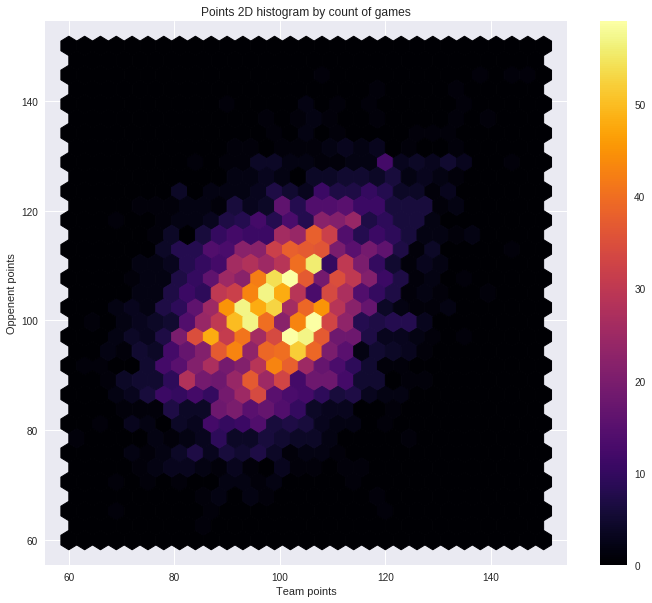

In [14]:
pl.figure(figsize=[11.7,10])
hb = pl.hexbin(df['points'], df['opponent_points'], gridsize=30, cmap='inferno', extent=[60, 150, 60, 150])
pl.xlabel('Team points')
pl.ylabel('Oppenent points')
pl.title('Points 2D histogram by count of games')
pl.colorbar()
pl.show()

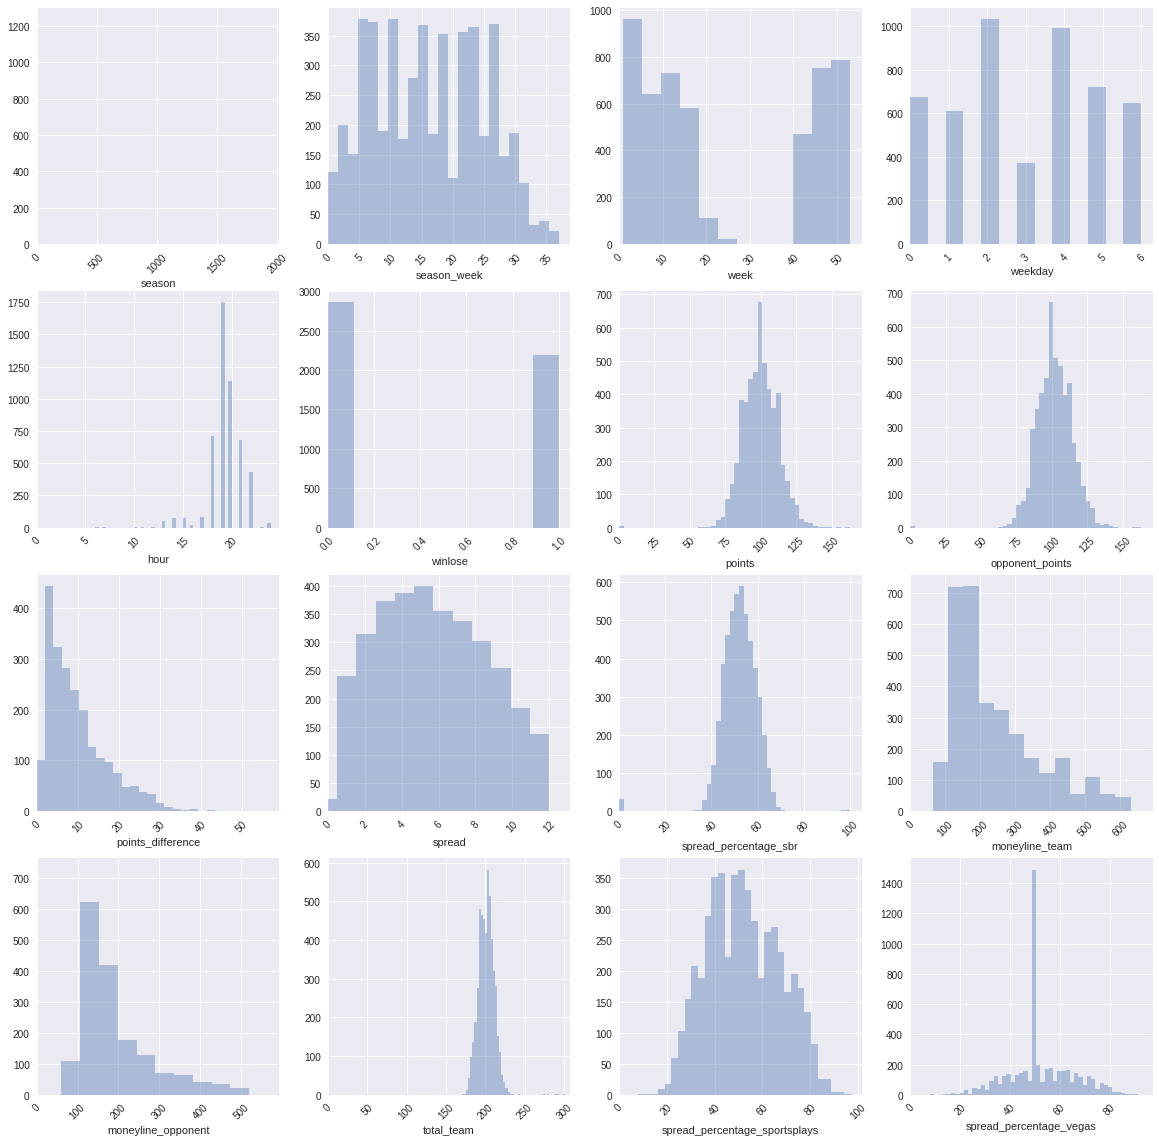

In [15]:
for i, f in enumerate(features):
    plt.subplot(4, 4,i+1)
    fig = plt.gcf()
    fig.set_size_inches(20,20)
    sns.distplot(df[f], kde=False)
    plt.xlim(0)
    plt.xticks(rotation=45)
plt.show()

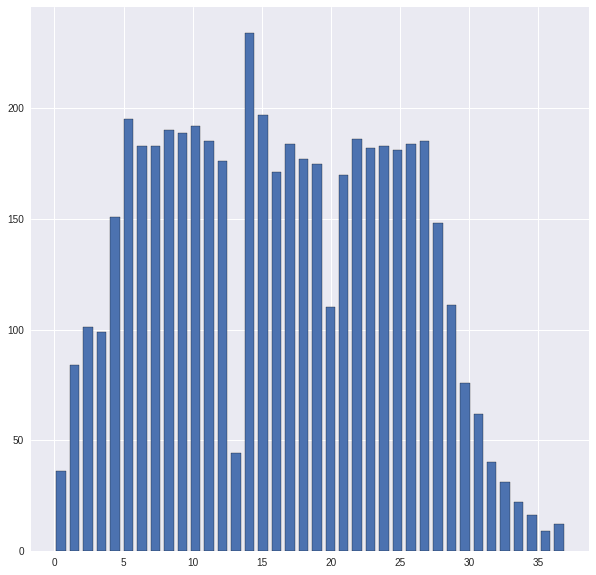

In [16]:
season_week = np.array(df['season_week'])
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(season_week, bins=len(set(df.season_week)), edgecolor='black', rwidth=0.7)
pl.grid(True)
pl.show()

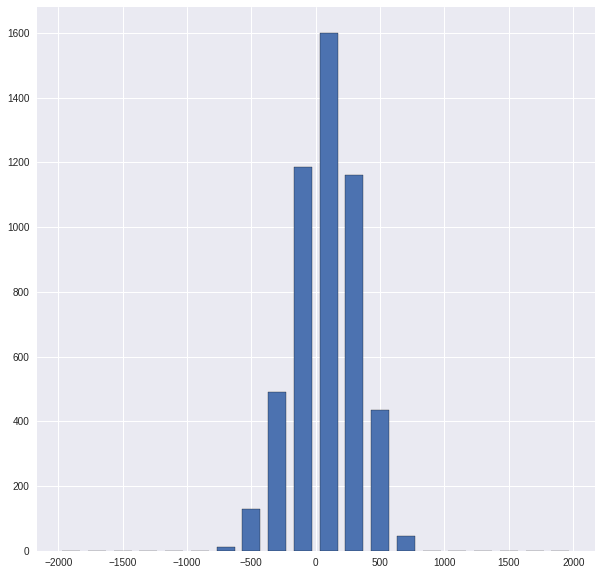

In [17]:
moneyline_team = np.array(df['moneyline_team'])
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(moneyline_team, bins=20, edgecolor='black', rwidth=0.7, range=(-2000, 2000))
pl.grid(True)
pl.show()

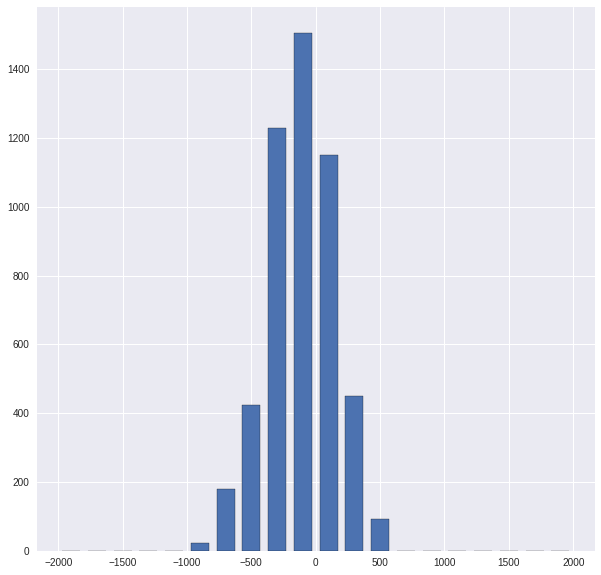

In [18]:
moneyline_opponent = np.array(df['moneyline_opponent'])
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(moneyline_opponent, bins=20, edgecolor='black', rwidth=0.7, range=(-2000, 2000))
pl.grid(True)
pl.show()

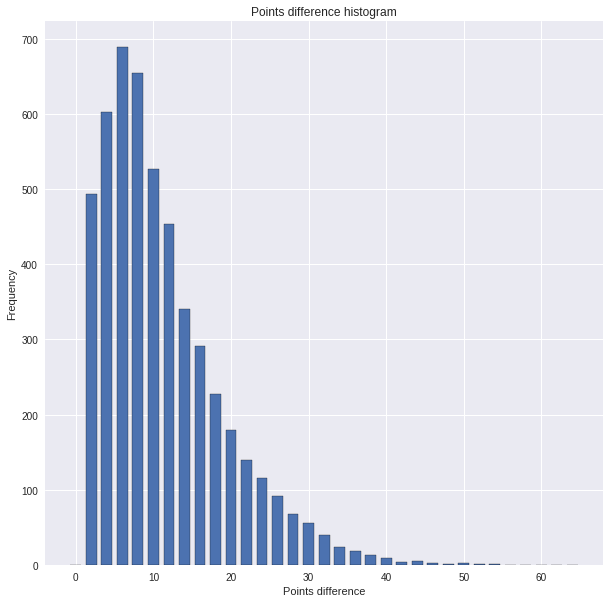

In [20]:
pts_diff = np.array(df['points_difference'])
pts_diff = np.abs(pts_diff)[pts_diff!=0]
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(pts_diff, bins=33, edgecolor='black', range=(-1, 65), rwidth=0.7)
pl.title('Points difference histogram')
pl.xlabel('Points difference')
pl.ylabel('Frequency')
# pl.xticks(range(-70,70,2))
pl.grid(True)
pl.show()

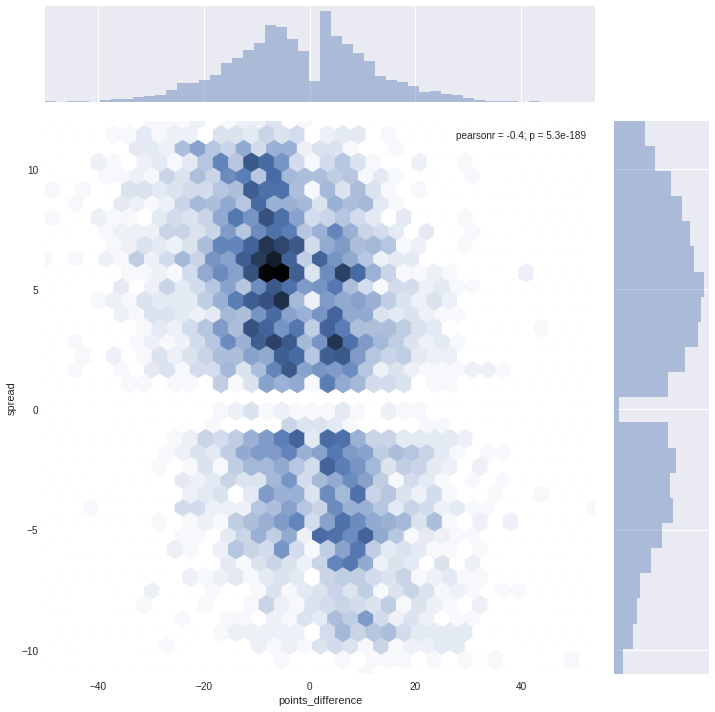

In [21]:
x = df.points_difference
y = df.spread
sns.jointplot(x=x, y=y, kind='hex', size=10)
pl.show()

## Get most similiar games

In [22]:
def get_report(_id):
    w_av =np.average(similar_games[_id].points_difference[1:], weights=similar_games[_id].distance[1:])
    print('Weighted average points_difference for simillar games', w_av)
    print('Average points_difference for simillar games', \
          np.average(similar_games[_id].points_difference[1:]))
    pl.figure(figsize=[10,10])
    x = df.points_difference
    y = df.spread
    pl.scatter(x, y, c='lightblue', s=5, )
    
    top = 20
    x1 = similar_games[_id].points_difference
    y1 = similar_games[_id].spread
    pl.scatter(x1[:top], y1[:top], c='red', s=10)
    plt.xlim(-50,  40)
    plt.ylim(-20, 30)
    pl.xlabel('Points difference')
    pl.ylabel('Spred')
    pl.title('Show on the scatter the nearest games to the given game of 2017 season NCAA Basketball (id {})'.format(_id))
    pl.show()
    return w_av

In [23]:
distance_features = ['season_week', 'spread', 'spread_percentage_sbr', 'moneyline_team',\
       'moneyline_opponent', \
       'spread_percentage_sportsplays',]# 'spread_percentage_vegas']

def get_similar_games(games, games_history, metric='euclidean', top=1000):
    scaler = MinMaxScaler()
    scaled_history = scaler.fit_transform(np.array(games_history[distance_features].values))
    scaled_games = scaler.transform(games[distance_features].values)
    dists = pairwise_distances(scaled_games, scaled_history, metric=metric, n_jobs=4)
    result = []
    for d in dists:
        args = d.argsort()
        similar_games = games_history.iloc[args[:top]]
        similar_games.insert(0, 'distance', d[args[:top]])
#         similar_games = similar_games[similar_games.distance > 0.001]
        result.append(similar_games)
    return result

In [24]:
def get_pds(games, similar_games, top=100, weighted=True):
    games_history = df[features].values
    pds = []
    for game, sim_games in zip(games.itertuples(), similar_games):
        tmp = sim_games[np.logical_or(sim_games.year < game.year,\
                                       sim_games.week < game.week)]
        tmp = tmp[tmp.distance > 0.0001]
        if weighted:
    #             print(tmp.distance[:top])
            av_pd = np.average(tmp.points_difference[:top], weights=tmp.distance[:top])
        else:
            av_pd = np.average(tmp.points_difference[:top])
        pds.append(av_pd)
    return pds


In [25]:
def get_scores(games, pds):
    winpred = [1 if i > 0 else 0 for i in pds]
    wintest = [1 if i > 0 else 0 for i in games.points_difference]
    acc = accuracy_score(wintest, winpred)
    rec = recall_score(wintest, winpred)
    f1 = f1_score(wintest, winpred)
    mse = mean_squared_error(games.points_difference, pds)
    mae = mean_absolute_error(games.points_difference, pds)
    print('Accuracy score {:.5f}'.format(acc))
    print('MSE      score {:.5f}'.format(mse))
    print('MAE      score {:.5f}'.format(mae))
    return acc, mse, mae

In [68]:
msess = []
accss = []
maess = []
for season in (2014, 2015, 2016):
    games = df[df.season == season]
    history = df[[i in games.index for i in df.index]]
    similar_games = get_similar_games(games, df)
    print('Season {}, {} games'.format(season, len(games)))
    mses = []
    accs = []
    maes = []
    tops = list(range(25, 110, 25))
    for top in tops:
        print('Using top {} games'.format(top))
        pds = get_pds(games, similar_games, top=top)
        acc, mse, mae = get_scores(games, pds)
        mses.append(mse)
        accs.append(acc)
        maes.append(mae)
        print('-'*100)
    maess.append(maes)
    accss.append(accs)
    msess.append(mses)
    print('-'*100)
    
    # print(winlose)

Season 2014, 1240 games
Using top 25 games
Accuracy score 0.65081
MSE      score 149.71344
MAE      score 9.54533
----------------------------------------------------------------------------------------------------
Using top 50 games
Accuracy score 0.65565
MSE      score 146.64364
MAE      score 9.37425
----------------------------------------------------------------------------------------------------
Using top 75 games
Accuracy score 0.66774
MSE      score 145.41782
MAE      score 9.39351
----------------------------------------------------------------------------------------------------
Using top 100 games
Accuracy score 0.66935
MSE      score 144.54814
MAE      score 9.35364
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Season 2015, 1228 games
Using top 25 games
Accuracy score 0.65717
MSE      score 149.77956
MAE      score 9.62

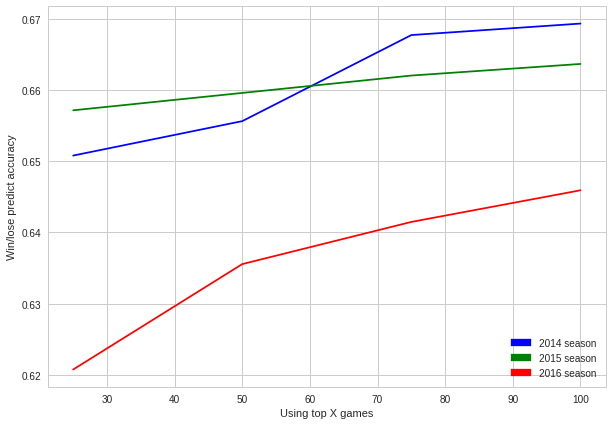

In [69]:
sns.set_style("whitegrid")
pl.figure(figsize=(10,7))
# sns.pointplot(list(range(5, 205, 5)), msess[1], markers='.', )
pl.plot(tops, accss[0], c='blue')
pl.plot(tops, accss[1], c='green')
pl.plot(tops, accss[2], c='red')
pl.xlabel('Using top X games')
pl.ylabel('Win/lose predict accuracy')
blue_patch = mpatches.Patch(color='blue', label='2014 season')
green_patch = mpatches.Patch(color='green', label='2015 season')
red_patch = mpatches.Patch(color='red', label='2016 season')

plt.legend(handles=[blue_patch, green_patch, red_patch], loc=4)
pl.show()

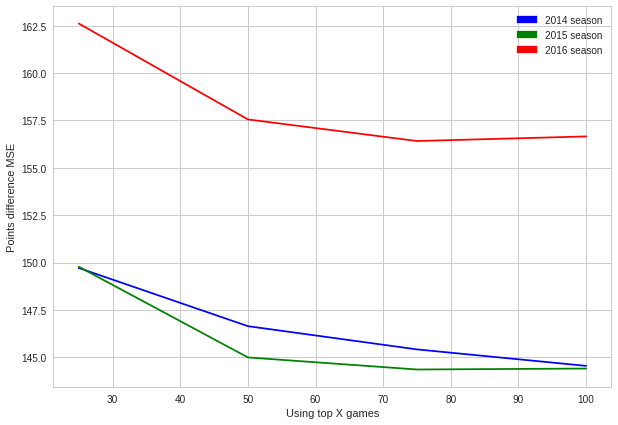

In [70]:
sns.set_style("whitegrid")
pl.figure(figsize=(10,7))
# sns.pointplot(list(range(5, 205, 5)), msess[1], markers='.', )
pl.plot(tops, msess[0], c='blue')
pl.plot(tops, msess[1], c='green')
pl.plot(tops, msess[2], c='red')
pl.xlabel('Using top X games')
pl.ylabel('Points difference MSE')
blue_patch = mpatches.Patch(color='blue', label='2014 season')
green_patch = mpatches.Patch(color='green', label='2015 season')
red_patch = mpatches.Patch(color='red', label='2016 season')

plt.legend(handles=[blue_patch, green_patch, red_patch], loc=1)
pl.show()

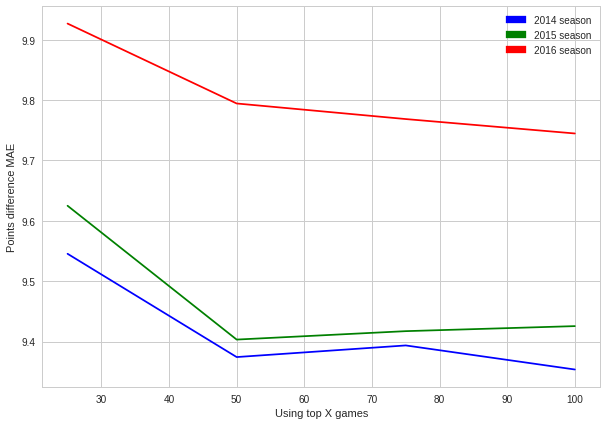

In [71]:
sns.set_style("whitegrid")
pl.figure(figsize=(10,7))
# sns.pointplot(list(range(5, 205, 5)), msess[1], markers='.', )
pl.plot(tops, maess[0], c='blue')
pl.plot(tops, maess[1], c='green')
pl.plot(tops, maess[2], c='red')
pl.xlabel('Using top X games')
pl.ylabel('Points difference MAE')
blue_patch = mpatches.Patch(color='blue', label='2014 season')
green_patch = mpatches.Patch(color='green', label='2015 season')
red_patch = mpatches.Patch(color='red', label='2016 season')

plt.legend(handles=[blue_patch, green_patch, red_patch], loc=1)
pl.show()

## Predict new games

In [26]:
def edit_csv_v2(df):
    df = df.fillna(0)

    dates = np.array(df.date)
    dates = [dt.strptime(str(i), '%Y%m%d').date() for i in dates]
    #add time
    hours = []
    for i in df.time:
        if i[-1] == 'p':
            hours.append(12+int(i.split(':')[0]))
        else:
            hours.append(int(i.split(':')[0]))
    df.insert(1, 'hour', hours)

    #add week day
    weekdays = [i.weekday() for i in dates]
    df.insert(1, 'weekday', weekdays)

    #add weeknums
    weeknums = [i.isocalendar()[1] for i in dates]
    df.insert(1, 'week', weeknums)

    #add win/lose
    winloses = [1 if i>0 else 0 for i in df.points_difference]
    df.insert(1, 'winlose', winloses)
    df.drop('win_against_spread', axis=1)

    #add seasons
    seasons = [i.year for i in dates]
    df.insert(1, 'year', seasons)

    #add column season_week
    season_start = 40
    season_end = 24
    season_week = []
    for y, w in zip(df.year, df.week):
        if w >= season_start:
            sw = w - 40
        else:
            sw = w - 40 + 53
        season_week.append(sw)
    df.insert(0, 'season_week', season_week)
    df.head()

    season = []
    year = 2016
    for sw in df.season_week:
        season.append(year)
    df.insert(0, 'season', season)

    df.total_team = df.total_opponent
    delete_columns = ['date', 'time', 'win_against_spread', 'total_opponent']
    df = df.drop(delete_columns, axis=1)
#     df = df.reset_index(drop=True)
    print('Dataframe length',len(df))
    return df
    

In [27]:
def prepare_predict(games):
    similar_games = get_similar_games(games, df)
    pds = get_pds(games, similar_games)
    games.insert(0, 'distance', 0.0)
#     print(pds, len(games), len(similar_games))
    games.points_difference = pds
    for i in range(len(games)):
        tmp = pd.DataFrame(games.iloc[i]).T
        tmp.points_difference
        similar_games[i] = pd.concat([tmp, similar_games[i]], axis=0)
    for sg in similar_games:
        t = sg.iloc[0].team
        op = sg.iloc[0].opponent_team
        dt = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M')
        path = 'predictions/{}_{}-{}.csv'.format(dt, t, op)
        sg.to_csv(path, index=False)
    return similar_games

In [125]:
path = 'seeds/27042017nba.csv'
games = pd.read_csv(path)
games = edit_csv_v2(games)
sgs = prepare_predict(games)


Dataframe length 2


In [112]:

port = 22
def init_sftp():
    transport = paramiko.Transport((host, port))
    transport.connect(username=user, password=secret)
    sftp = paramiko.SFTPClient.from_transport(transport)
    return sftp

In [116]:
remote_path = '/cygdrive/c/nba_data/input/'
local_path = 'input/processing/'
def get_last_file(sftp):
    try:
        name = sftp.listdir(remote_path)[-1]
        remote_filepath = remote_path + name
        local_filepath = local_path + name
        sftp.get(remote_filepath, local_filepath)
        print('Got file:', name)
    except Exception as e:
        print('Error: ', e)
        print('Last processed file: ', remote_filepath)
        get_last_file(sftp)

In [119]:
sftp = init_sftp()
get_last_file(sftp)

Got file: test_SBR_NBA_2017_Line_Moves_daily.csv


In [275]:
bound = datetime.datetime(2017, 4, 28, 5)
while time.time() < bound.timestamp():
    sftp = init_sftp()
    get_last_file(sftp)
    
    proc_path = 'input/processing/'
    filepath = path = os.listdir(path)[-1]
    games = pd.read_csv(path)
    games = edit_csv_v2(games)
    prepare_predict(games)
    print('Sleeping for 110 seconds')
    time.sleep(110)
    

Dataframe length 2
Sleeping for 60 seconds


KeyboardInterrupt: 

In [123]:
sftp.close()